In [1]:
from google.colab import drive
import os 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow.keras as tfk 
import tensorflow.keras.layers as tfkl 
plt.rc('font', size=16) 
import random
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from sklearn import preprocessing 


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [2]:
# Random seed for reproducibility
seed = 89
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
from google.colab import drive

In [4]:
drive.mount('/gdrive')
os.chdir(r'/gdrive/MyDrive/annHomework2/')
x_train = np.load(r'x_train.npy')
y_train = np.load(r'y_train.npy')

Mounted at /gdrive


In [5]:
x_train.shape, y_train.shape 

((2429, 36, 6), (2429,))

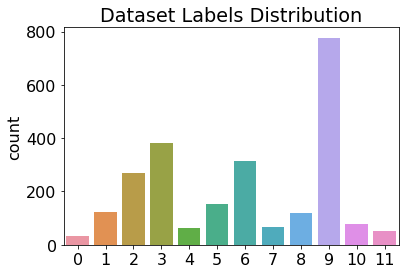

In [6]:
# plot labels distribution 
sns.countplot( x = y_train) 
plt.title('Dataset Labels Distribution')
plt.show()

In [7]:
labels = np.unique(np.fromiter([i for i in y_train], np.int32) )
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=labels, y=y_train) 

In [8]:
# interpolation 
from scipy.interpolate import interp1d
x_new = [] 
for el in x_train: 
    interp = interp1d(x=np.arange(36), y=el, axis=0, kind='cubic')
    el = interp(np.arange(0, 35, .3))
    x_new.append(el)
x_new = np.array(x_new) 
print(x_new.shape) 
x_train = x_new
y_train = tfk.utils.to_categorical(y_train) 

(2429, 117, 6)


In [9]:
# 
train_data = np.concatenate([x for x in x_train]) 
scaler = preprocessing.StandardScaler().fit(train_data)

x_train_trans = [] 
for el in x_train: 
  x_train_trans.append(scaler.transform(el))
del x_train 

x_train = np.asarray(x_train_trans) 


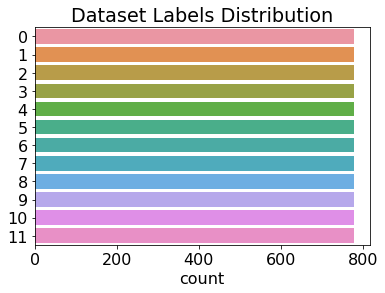

(9324, 702) (9324, 12)
(9324, 117, 6) (9324, 12)


In [10]:
OLD_SHAPE = x_train.shape[1]
x_train_reshaped = tf.reshape(x_train, shape = (x_train.shape[0], x_train.shape[1]*6) )

from imblearn.over_sampling import RandomOverSampler, SVMSMOTE, SMOTE
from imblearn.combine import SMOTEENN

ros = SMOTE(sampling_strategy='not majority' ,random_state=seed)
train_data, labels = ros.fit_resample(x_train_reshaped, y_train)

plotting_labels = np.argmax(labels, axis = 1)
sns.countplot( y = plotting_labels) 
plt.title('Dataset Labels Distribution')
plt.show()

print(train_data.shape, labels.shape) 
x_res = tf.reshape(train_data, shape = (train_data.shape[0], OLD_SHAPE, 6) ) 
y_res = labels 
print(x_res.shape, y_res.shape)

In [11]:
# check 
print(x_train.shape, y_train.shape) 
x_train[0][1]
y_train[0]

(2429, 117, 6) (2429, 12)


array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

**bagging training sets**

In [12]:
x_train1, x_test1, y_train1, y_test1 = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=1, stratify=y_train)
x_train2, x_test2, y_train2, y_test2 = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=2, stratify=y_train)
x_train3, x_test3, y_train3, y_test3 = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=3, stratify=y_train)
x_train4, x_test4, y_train4, y_test4 = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=4, stratify=y_train)
x_train5, x_test5, y_train5, y_test5 = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=5, stratify=y_train)
x_train6, x_test6, y_train6, y_test6 = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=6, stratify=y_train)
x_train7, x_test7, y_train7, y_test7 = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=7, stratify=y_train)
x_train8, x_test8, y_train8, y_test8 = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=8, stratify=y_train)
x_train9, x_test9, y_train9, y_test9 = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=9, stratify=y_train)
x_train10, x_test10, y_train10, y_test10 = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=10, stratify=y_train)

In [13]:
input_shape = (117,6) 

In [14]:
# ubernet : norm + skip + attention 
def build_ffnn_classifier(input_shape, classes):
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    x = input_layer
    x = tfkl.GaussianNoise(seed=seed, stddev=0.001) (x)
    cnn_1 = tfkl.Conv1D(256,3,padding='same',activation='relu')(x) 
    cnn = tfkl.MaxPooling1D()(cnn_1)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    x = tfkl.MultiHeadAttention( key_dim=6, num_heads=5, dropout=0.3 )(cnn,tfkl.MaxPool1D(strides = 2)(input_layer)) 
    x = tfkl.Add()([cnn, tfkl.MaxPool1D(strides = 4)(cnn_1) ])
    
    norm = tfkl.BatchNormalization()(x)
    
    cnn_1 = tfkl.Conv1D(256,3,padding='same',activation='relu')(norm) 
    cnn = tfkl.MaxPooling1D()(cnn_1)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    
    x = tfkl.MultiHeadAttention( key_dim=6, num_heads=5, dropout=0.3 )(cnn,tfkl.MaxPool1D(strides = 2)(cnn) ) 
    x = tfkl.Add()([cnn, tfkl.MaxPool1D(strides = 4)(cnn_1)  ])
    norm = tfkl.BatchNormalization()(x)
    
    gap = tfkl.GlobalAveragePooling1D()(norm)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)

    hidden_layer1 = tfkl.Dense(units=256, activation ='relu', name = 'Hidden1', kernel_regularizer = tfk.regularizers.L2(l2 = 0.003))(dropout) 
    dropout = tfkl.Dropout(.3, seed=seed)(hidden_layer1)
    hidden_layer2 = tfkl.Dense(units=256, activation ='relu', name = 'Hidden2', kernel_regularizer = tfk.regularizers.L2(l2 = 0.003))(dropout) 
    
    output_layer = tfkl.Dense(classes, activation='softmax', 
                              kernel_initializer=tfk.initializers.GlorotUniform(seed))(hidden_layer2)
      
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    return model

In [15]:
model1 = build_ffnn_classifier(input_shape, 12)
model2 = build_ffnn_classifier(input_shape, 12)
model3 = build_ffnn_classifier(input_shape, 12)
model4 = build_ffnn_classifier(input_shape, 12)
model5 = build_ffnn_classifier(input_shape, 12)
model6 = build_ffnn_classifier(input_shape, 12)
model7 = build_ffnn_classifier(input_shape, 12)
model8 = build_ffnn_classifier(input_shape, 12)
model9 = build_ffnn_classifier(input_shape, 12)
model10 = build_ffnn_classifier(input_shape, 12)

model7.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 117, 6)]     0           []                               
                                                                                                  
 gaussian_noise_6 (GaussianNois  (None, 117, 6)      0           ['Input[0][0]']                  
 e)                                                                                               
                                                                                                  
 conv1d_36 (Conv1D)             (None, 117, 256)     4864        ['gaussian_noise_6[0][0]']       
                                                                                                  
 max_pooling1d_48 (MaxPooling1D  (None, 58, 256)     0           ['conv1d_36[0][0]']          

# training

In [16]:
history1 = model1.fit(
    x = x_train1,
    y = y_train1,
    batch_size = 64,
    epochs = 200,
    validation_data = (x_test1, y_test1),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=15, factor=0.3, min_lr=1e-5)
    ]
).history

Epoch 1/200
31/31 [==============================] - 12s 45ms/step - loss: 3.5211 - accuracy: 0.3546 - val_loss: 3.7017 - val_accuracy: 0.0926 - lr: 0.0010
Epoch 2/200
31/31 [==============================] - 0s 13ms/step - loss: 3.0421 - accuracy: 0.4328 - val_loss: 3.8583 - val_accuracy: 0.1214 - lr: 0.0010
Epoch 3/200
31/31 [==============================] - 0s 14ms/step - loss: 2.7269 - accuracy: 0.4725 - val_loss: 3.9496 - val_accuracy: 0.1235 - lr: 0.0010
Epoch 4/200
31/31 [==============================] - 0s 14ms/step - loss: 2.5099 - accuracy: 0.5126 - val_loss: 3.6057 - val_accuracy: 0.1255 - lr: 0.0010
Epoch 5/200
31/31 [==============================] - 0s 14ms/step - loss: 2.3546 - accuracy: 0.5301 - val_loss: 3.1772 - val_accuracy: 0.1255 - lr: 0.0010
Epoch 6/200
31/31 [==============================] - 0s 14ms/step - loss: 2.1597 - accuracy: 0.5630 - val_loss: 3.6010 - val_accuracy: 0.1317 - lr: 0.0010
Epoch 7/200
31/31 [==============================] - 0s 14ms/step - l

In [17]:
history2 = model2.fit(
    x = x_train2,
    y = y_train2,
    batch_size = 64,
    epochs = 200,
    validation_data = (x_test2, y_test2),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=15, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
31/31 [==============================] - 2s 25ms/step - loss: 3.4685 - accuracy: 0.3659 - val_loss: 3.6254 - val_accuracy: 0.1584 - lr: 0.0010
Epoch 2/200
31/31 [==============================] - 0s 13ms/step - loss: 3.0177 - accuracy: 0.4467 - val_loss: 3.6707 - val_accuracy: 0.1337 - lr: 0.0010
Epoch 3/200
31/31 [==============================] - 0s 12ms/step - loss: 2.7518 - accuracy: 0.4725 - val_loss: 3.5011 - val_accuracy: 0.1461 - lr: 0.0010
Epoch 4/200
31/31 [==============================] - 0s 14ms/step - loss: 2.5430 - accuracy: 0.5080 - val_loss: 3.0963 - val_accuracy: 0.2819 - lr: 0.0010
Epoch 5/200
31/31 [==============================] - 0s 13ms/step - loss: 2.3219 - accuracy: 0.5564 - val_loss: 3.1574 - val_accuracy: 0.2695 - lr: 0.0010
Epoch 6/200
31/31 [==============================] - 0s 13ms/step - loss: 2.1677 - accuracy: 0.5780 - val_loss: 2.7649 - val_accuracy: 0.4198 - lr: 0.0010
Epoch 7/200
31/31 [==============================] - 0s 14ms/step - lo

In [18]:
history3 = model3.fit(
    x = x_train3,
    y = y_train3,
    batch_size = 64,
    epochs = 200,
    validation_data = (x_test3, y_test3),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=15, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
31/31 [==============================] - 2s 27ms/step - loss: 3.4969 - accuracy: 0.3474 - val_loss: 3.6631 - val_accuracy: 0.1708 - lr: 0.0010
Epoch 2/200
31/31 [==============================] - 0s 13ms/step - loss: 3.0687 - accuracy: 0.4303 - val_loss: 3.5690 - val_accuracy: 0.2016 - lr: 0.0010
Epoch 3/200
31/31 [==============================] - 0s 13ms/step - loss: 2.7542 - accuracy: 0.4838 - val_loss: 3.4947 - val_accuracy: 0.1975 - lr: 0.0010
Epoch 4/200
31/31 [==============================] - 0s 13ms/step - loss: 2.5219 - accuracy: 0.5162 - val_loss: 3.5620 - val_accuracy: 0.1852 - lr: 0.0010
Epoch 5/200
31/31 [==============================] - 0s 12ms/step - loss: 2.3469 - accuracy: 0.5502 - val_loss: 3.4874 - val_accuracy: 0.1872 - lr: 0.0010
Epoch 6/200
31/31 [==============================] - 0s 14ms/step - loss: 2.2065 - accuracy: 0.5636 - val_loss: 3.1039 - val_accuracy: 0.2222 - lr: 0.0010
Epoch 7/200
31/31 [==============================] - 0s 13ms/step - lo

In [19]:
history4 = model4.fit(
    x = x_train4,
    y = y_train4,
    batch_size = 64,
    epochs = 200,
    validation_data = (x_test4, y_test4),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=15, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
31/31 [==============================] - 2s 22ms/step - loss: 3.4763 - accuracy: 0.3582 - val_loss: 3.6675 - val_accuracy: 0.1296 - lr: 0.0010
Epoch 2/200
31/31 [==============================] - 0s 14ms/step - loss: 3.0005 - accuracy: 0.4545 - val_loss: 3.7625 - val_accuracy: 0.1276 - lr: 0.0010
Epoch 3/200
31/31 [==============================] - 0s 13ms/step - loss: 2.7242 - accuracy: 0.4853 - val_loss: 3.5526 - val_accuracy: 0.1770 - lr: 0.0010
Epoch 4/200
31/31 [==============================] - 0s 13ms/step - loss: 2.5890 - accuracy: 0.4936 - val_loss: 3.4248 - val_accuracy: 0.2325 - lr: 0.0010
Epoch 5/200
31/31 [==============================] - 0s 13ms/step - loss: 2.4015 - accuracy: 0.5306 - val_loss: 3.1723 - val_accuracy: 0.2449 - lr: 0.0010
Epoch 6/200
31/31 [==============================] - 0s 14ms/step - loss: 2.2217 - accuracy: 0.5574 - val_loss: 2.7949 - val_accuracy: 0.3313 - lr: 0.0010
Epoch 7/200
31/31 [==============================] - 0s 13ms/step - lo

In [20]:
history5 = model5.fit(
    x = x_train5,
    y = y_train5,
    batch_size = 64,
    epochs = 200,
    validation_data = (x_test5, y_test5),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=15, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
31/31 [==============================] - 2s 22ms/step - loss: 3.4909 - accuracy: 0.3603 - val_loss: 3.7128 - val_accuracy: 0.1193 - lr: 0.0010
Epoch 2/200
31/31 [==============================] - 0s 13ms/step - loss: 3.0439 - accuracy: 0.4406 - val_loss: 3.7038 - val_accuracy: 0.1399 - lr: 0.0010
Epoch 3/200
31/31 [==============================] - 0s 13ms/step - loss: 2.7790 - accuracy: 0.4627 - val_loss: 3.5529 - val_accuracy: 0.1152 - lr: 0.0010
Epoch 4/200
31/31 [==============================] - 0s 14ms/step - loss: 2.5156 - accuracy: 0.5322 - val_loss: 3.0460 - val_accuracy: 0.2243 - lr: 0.0010
Epoch 5/200
31/31 [==============================] - 0s 13ms/step - loss: 2.3854 - accuracy: 0.5455 - val_loss: 2.9969 - val_accuracy: 0.2387 - lr: 0.0010
Epoch 6/200
31/31 [==============================] - 0s 13ms/step - loss: 2.2327 - accuracy: 0.5481 - val_loss: 2.6470 - val_accuracy: 0.4918 - lr: 0.0010
Epoch 7/200
31/31 [==============================] - 0s 12ms/step - lo

In [21]:
history6 = model6.fit(
    x = x_train6,
    y = y_train6,
    batch_size = 64,
    epochs = 200,
    validation_data = (x_test6, y_test6),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=15, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
31/31 [==============================] - 2s 33ms/step - loss: 3.4979 - accuracy: 0.3556 - val_loss: 3.6796 - val_accuracy: 0.1214 - lr: 0.0010
Epoch 2/200
31/31 [==============================] - 0s 13ms/step - loss: 2.9786 - accuracy: 0.4534 - val_loss: 3.5994 - val_accuracy: 0.1399 - lr: 0.0010
Epoch 3/200
31/31 [==============================] - 0s 13ms/step - loss: 2.7162 - accuracy: 0.4843 - val_loss: 3.3028 - val_accuracy: 0.1852 - lr: 0.0010
Epoch 4/200
31/31 [==============================] - 0s 13ms/step - loss: 2.4879 - accuracy: 0.5214 - val_loss: 3.2217 - val_accuracy: 0.1687 - lr: 0.0010
Epoch 5/200
31/31 [==============================] - 0s 13ms/step - loss: 2.3362 - accuracy: 0.5404 - val_loss: 2.7636 - val_accuracy: 0.4280 - lr: 0.0010
Epoch 6/200
31/31 [==============================] - 0s 12ms/step - loss: 2.2275 - accuracy: 0.5481 - val_loss: 2.8377 - val_accuracy: 0.2284 - lr: 0.0010
Epoch 7/200
31/31 [==============================] - 0s 13ms/step - lo

In [22]:
history7 = model7.fit(
    x = x_train7,
    y = y_train7,
    batch_size = 64,
    epochs = 200,
    validation_data = (x_test7, y_test7),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=15, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
31/31 [==============================] - 2s 22ms/step - loss: 3.4542 - accuracy: 0.3628 - val_loss: 3.7172 - val_accuracy: 0.1111 - lr: 0.0010
Epoch 2/200
31/31 [==============================] - 0s 14ms/step - loss: 3.0458 - accuracy: 0.4421 - val_loss: 3.7586 - val_accuracy: 0.1152 - lr: 0.0010
Epoch 3/200
31/31 [==============================] - 0s 13ms/step - loss: 2.7627 - accuracy: 0.4797 - val_loss: 3.7097 - val_accuracy: 0.1399 - lr: 0.0010
Epoch 4/200
31/31 [==============================] - 0s 14ms/step - loss: 2.5537 - accuracy: 0.5111 - val_loss: 3.5953 - val_accuracy: 0.2181 - lr: 0.0010
Epoch 5/200
31/31 [==============================] - 0s 13ms/step - loss: 2.3710 - accuracy: 0.5383 - val_loss: 3.5137 - val_accuracy: 0.2449 - lr: 0.0010
Epoch 6/200
31/31 [==============================] - 0s 14ms/step - loss: 2.2389 - accuracy: 0.5471 - val_loss: 2.6307 - val_accuracy: 0.4897 - lr: 0.0010
Epoch 7/200
31/31 [==============================] - 0s 12ms/step - lo

In [23]:
history8 = model8.fit(
    x = x_train8,
    y = y_train8,
    batch_size = 64,
    epochs = 200,
    validation_data = (x_test8, y_test8),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=15, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
31/31 [==============================] - 2s 22ms/step - loss: 3.4810 - accuracy: 0.3649 - val_loss: 3.6783 - val_accuracy: 0.1255 - lr: 0.0010
Epoch 2/200
31/31 [==============================] - 0s 13ms/step - loss: 3.0235 - accuracy: 0.4370 - val_loss: 3.8187 - val_accuracy: 0.1255 - lr: 0.0010
Epoch 3/200
31/31 [==============================] - 0s 13ms/step - loss: 2.6952 - accuracy: 0.4941 - val_loss: 3.5623 - val_accuracy: 0.2016 - lr: 0.0010
Epoch 4/200
31/31 [==============================] - 0s 13ms/step - loss: 2.4578 - accuracy: 0.5363 - val_loss: 3.3928 - val_accuracy: 0.1811 - lr: 0.0010
Epoch 5/200
31/31 [==============================] - 0s 13ms/step - loss: 2.3293 - accuracy: 0.5291 - val_loss: 3.3275 - val_accuracy: 0.1934 - lr: 0.0010
Epoch 6/200
31/31 [==============================] - 0s 13ms/step - loss: 2.2023 - accuracy: 0.5502 - val_loss: 3.2155 - val_accuracy: 0.2181 - lr: 0.0010
Epoch 7/200
31/31 [==============================] - 0s 13ms/step - lo

In [24]:
history9 = model9.fit(
    x = x_train9,
    y = y_train9,
    batch_size = 64,
    epochs = 200,
    validation_data = (x_test9, y_test9),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=15, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
31/31 [==============================] - 2s 26ms/step - loss: 3.5070 - accuracy: 0.3484 - val_loss: 3.7138 - val_accuracy: 0.1091 - lr: 0.0010
Epoch 2/200
31/31 [==============================] - 0s 13ms/step - loss: 3.0453 - accuracy: 0.4164 - val_loss: 3.7533 - val_accuracy: 0.1193 - lr: 0.0010
Epoch 3/200
31/31 [==============================] - 0s 13ms/step - loss: 2.7897 - accuracy: 0.4683 - val_loss: 3.6465 - val_accuracy: 0.1379 - lr: 0.0010
Epoch 4/200
31/31 [==============================] - 0s 12ms/step - loss: 2.5764 - accuracy: 0.5224 - val_loss: 3.3418 - val_accuracy: 0.1132 - lr: 0.0010
Epoch 5/200
31/31 [==============================] - 0s 14ms/step - loss: 2.3723 - accuracy: 0.5409 - val_loss: 3.1829 - val_accuracy: 0.2449 - lr: 0.0010
Epoch 6/200
31/31 [==============================] - 0s 14ms/step - loss: 2.2770 - accuracy: 0.5435 - val_loss: 3.1574 - val_accuracy: 0.2243 - lr: 0.0010
Epoch 7/200
31/31 [==============================] - 0s 12ms/step - lo

In [25]:
history10 = model10.fit(
    x = x_train10,
    y = y_train10,
    batch_size = 64,
    epochs = 200,
    validation_data = (x_test10, y_test10),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=15, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
31/31 [==============================] - 2s 27ms/step - loss: 3.4703 - accuracy: 0.3551 - val_loss: 3.7514 - val_accuracy: 0.1132 - lr: 0.0010
Epoch 2/200
31/31 [==============================] - 0s 13ms/step - loss: 3.0645 - accuracy: 0.4364 - val_loss: 3.6190 - val_accuracy: 0.1173 - lr: 0.0010
Epoch 3/200
31/31 [==============================] - 0s 14ms/step - loss: 2.7788 - accuracy: 0.4771 - val_loss: 3.4655 - val_accuracy: 0.1955 - lr: 0.0010
Epoch 4/200
31/31 [==============================] - 0s 15ms/step - loss: 2.5315 - accuracy: 0.5234 - val_loss: 3.2906 - val_accuracy: 0.2078 - lr: 0.0010
Epoch 5/200
31/31 [==============================] - 0s 14ms/step - loss: 2.3853 - accuracy: 0.5234 - val_loss: 3.1369 - val_accuracy: 0.2428 - lr: 0.0010
Epoch 6/200
31/31 [==============================] - 0s 13ms/step - loss: 2.2416 - accuracy: 0.5419 - val_loss: 2.8881 - val_accuracy: 0.2305 - lr: 0.0010
Epoch 7/200
31/31 [==============================] - 0s 14ms/step - lo

# evaluation

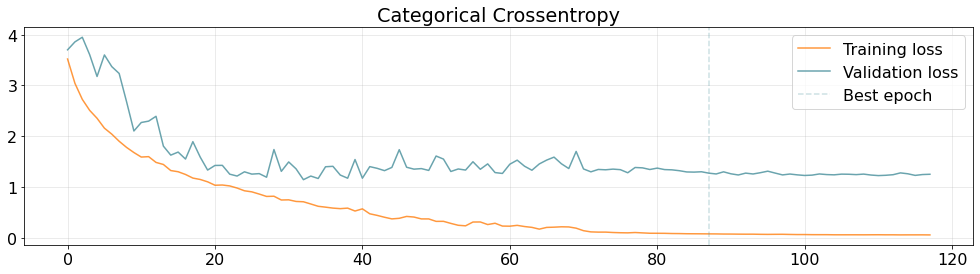

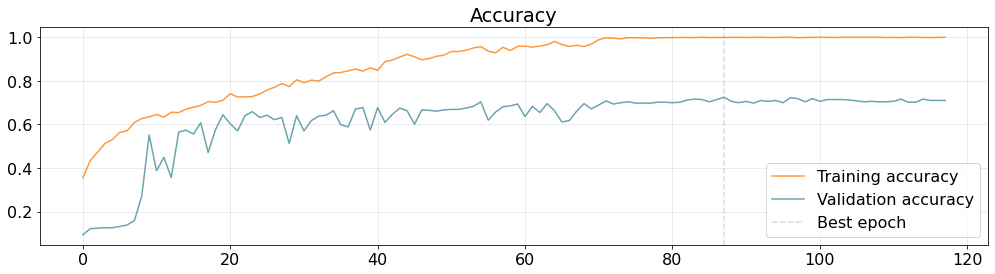

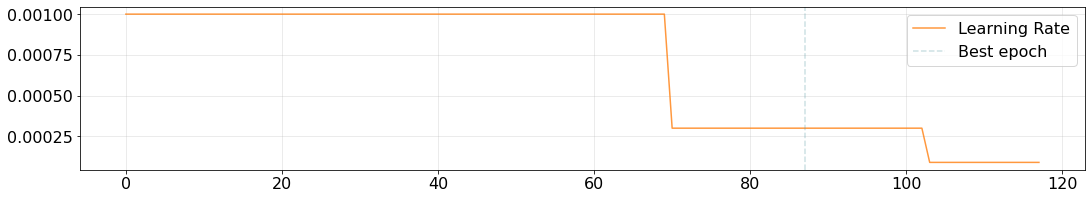

In [26]:
best_epoch = np.argmax(history1['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history1['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history1['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history1['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history1['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history1['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [27]:
predictions = model1.predict(x_test1)
predictions.shape

16/16 [==============================] - 1s 11ms/step


(486, 12)

16/16 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.0000e+00
{'loss': 0.06492339819669724, 'accuracy': 0.0}
16/16 [==============================] - 0s 3ms/step
Accuracy: 0.7243
Precision: 0.7308
Recall: 0.5916
F1: 0.6354
F1 (per class): [0.72727273 0.48888889 0.95327103 0.58646617 0.25       0.375
 0.84210526 0.4        0.93333333 0.75       0.96551724 0.35294118]


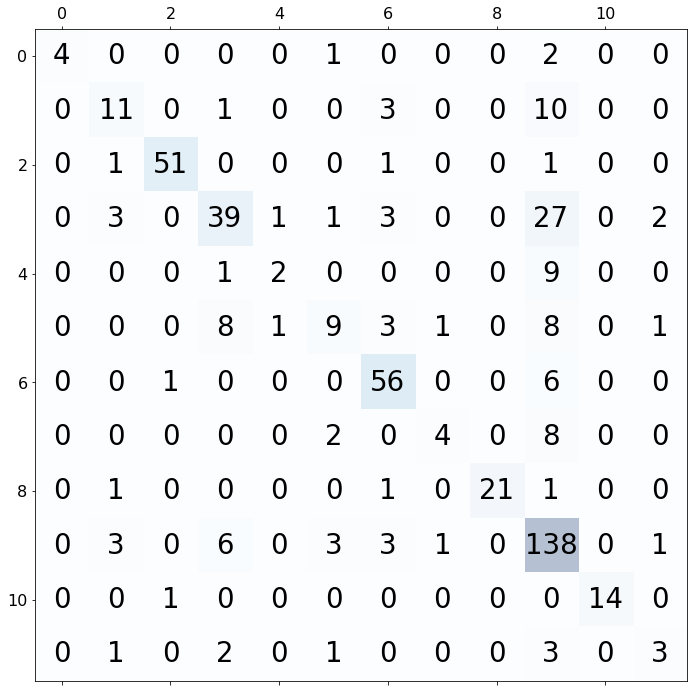

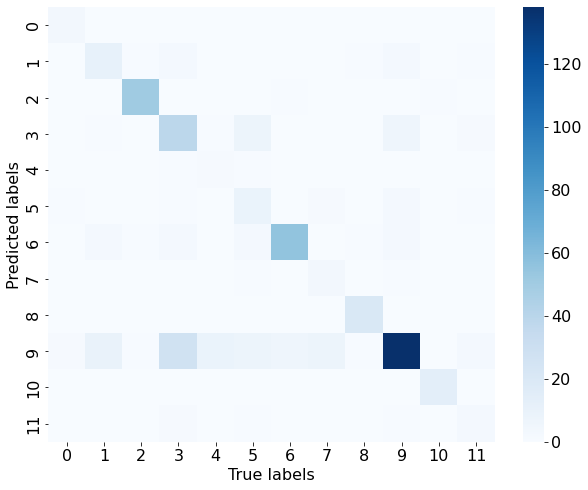

In [28]:
metrics = model1.evaluate(x_test1, return_dict=True)
print(metrics)

labels = y_test1 
predictions = model1.predict(x_test1) 
assert len(labels) == len(predictions)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1_classes = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average=None)

print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))
print('F1 (per class):' ,f1_classes)

# Plot the confusion matrix
ig, ax = plt.subplots(figsize=(12,12))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

        
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

16/16 [==============================] - 0s 4ms/step
Accuracy: 0.9815
Precision: 0.9927
Recall: 0.9515
F1: 0.9698
F1 (per class): [0.92307692 0.98039216 1.         0.98666667 0.90909091 0.98360656
 1.         0.88       1.         0.97484277 1.         1.        ]


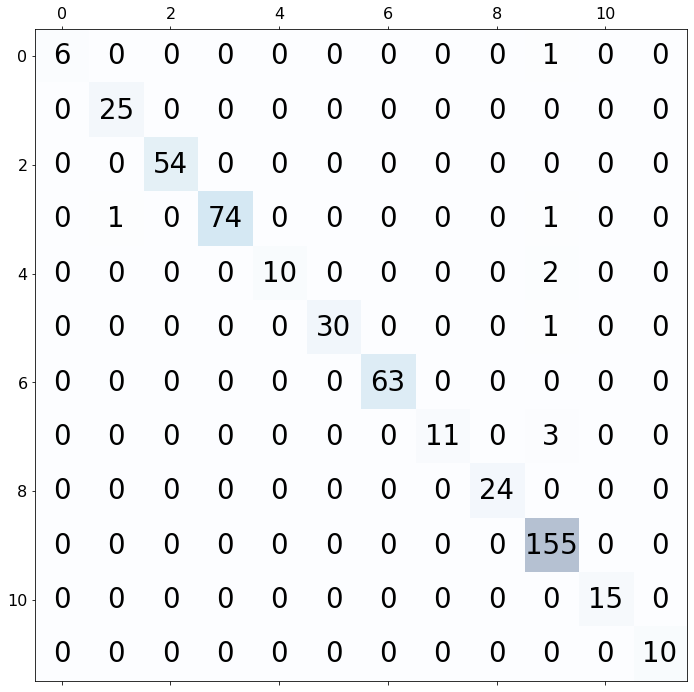

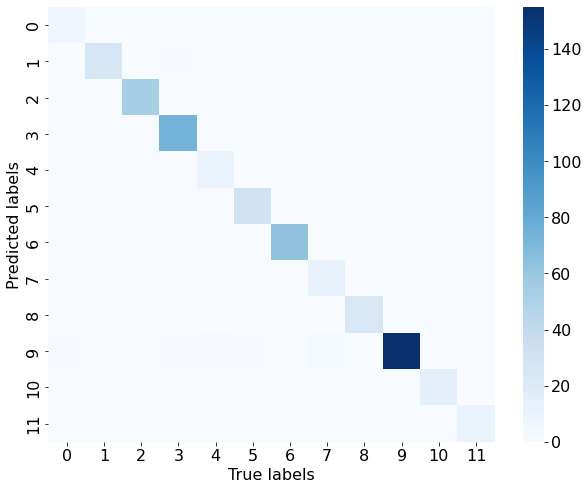

In [29]:
labels = y_test1 
p1 = model1.predict(x_test1)
p2 = model2.predict(x_test1)
p3 = model3.predict(x_test1)
p4 = model4.predict(x_test1)
p5 = model5.predict(x_test1)
p6 = model6.predict(x_test1)
p7 = model7.predict(x_test1)
p8 = model8.predict(x_test1)
p9 = model9.predict(x_test1)
p10 = model10.predict(x_test1)

predictions = (p1+p2+p3+p4+p5+p6+p7+p8+p9+p10)/10.0
assert len(labels) == len(predictions)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1_classes = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average=None)

print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))
print('F1 (per class):' ,f1_classes)

# Plot the confusion matrix
ig, ax = plt.subplots(figsize=(12,12))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

        
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# save

In [30]:
model1.save("bagging_model1")
model2.save("bagging_model2")
model3.save("bagging_model3")
model4.save("bagging_model4")
model5.save("bagging_model5")
model6.save("bagging_model6")
model7.save("bagging_model7")
model8.save("bagging_model8")
model9.save("bagging_model9")
model10.save("bagging_model10")

In [31]:
import pickle 

with open("scaler", r'wb') as f:  
  pickle.dump(scaler, f)

In [34]:
! zip -r subEnrico.zip bagging_model* scaler metadata model.py

  adding: bagging_model1/ (stored 0%)
  adding: bagging_model1/variables/ (stored 0%)
  adding: bagging_model1/variables/variables.index (deflated 74%)
  adding: bagging_model1/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: bagging_model1/assets/ (stored 0%)
  adding: bagging_model1/saved_model.pb (deflated 90%)
  adding: bagging_model1/keras_metadata.pb (deflated 93%)
  adding: bagging_model10/ (stored 0%)
  adding: bagging_model10/variables/ (stored 0%)
  adding: bagging_model10/variables/variables.index (deflated 74%)
  adding: bagging_model10/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: bagging_model10/assets/ (stored 0%)
  adding: bagging_model10/saved_model.pb (deflated 90%)
  adding: bagging_model10/keras_metadata.pb (deflated 93%)
  adding: bagging_model2/ (stored 0%)
  adding: bagging_model2/variables/ (stored 0%)
  adding: bagging_model2/variables/variables.index (deflated 74%)
  adding: bagging_model2/variables/variables.data-00000-of-00